# 卷积代码具体实现

误区澄清：输出的大小不一定等于输入图像的大小，这取决于使用的卷积方式（padding、stride）。

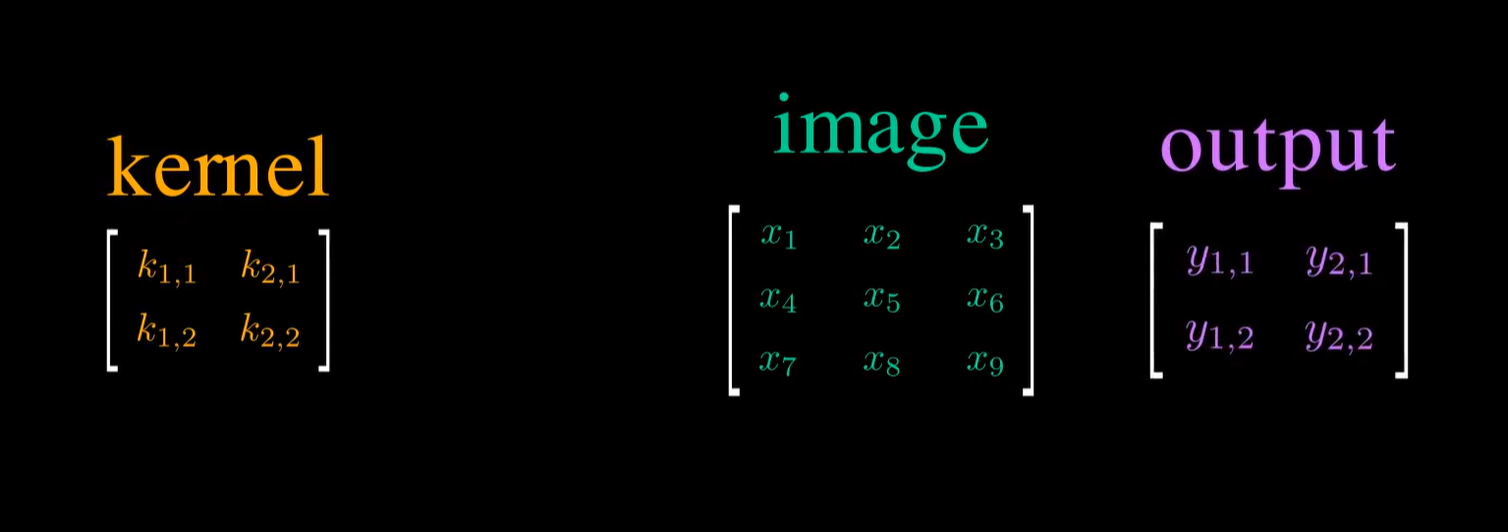

对于二维卷积，输出尺寸为：
$$
output\_size = \frac{input\_size-kernel\_size}{stride}+1
$$
一般而言stride=1,即每次移动一个像素

若想让输出和原图尺寸一样，需要添加 padding,且保证 padding = (kernel_size - 1) / 2

如果 kernel 是 3×3，则 padding = 1 → 输出尺寸不变  
如果 kernel 是 2×2，则 padding = 0.5 → 不行（必须整数）  
所以：只有当 kernel 是奇数时，才能通过 padding 让输出和输入一样大

## Padding函数

### zero-padding
在图像边缘补零（zero-padding），使得卷积核可以在边缘也能完整地覆盖。

In [2]:
import numpy as np
def padding(img, padding_size, type):
    """
        The function you need to implement for Q1 a).
        Inputs:
            img: array(float)
            padding_size: int
            type: str, zeroPadding/replicatePadding
        Outputs:
            padding_img: array(float)
    """
    height,width=img.shape

    padding_height=height+2*padding_size
    padding_width=width+2*padding_size

    if type=="zeroPadding":
        padding_img=np.zeros((padding_height,padding_width))
        padding_img[padding_size:-padding_size,padding_size:-padding_size]=img  
        return padding_img
    elif type=="replicatePadding":
        padding_img=np.empty((padding_height,padding_width))
        padding_img[padding_size:-padding_size,padding_size:-padding_size]=img

        # 填充上下行
        padding_img[0:padding_size,padding_size:-padding_size]=img[0,:] # 0:padding_size而不是0
        padding_img[-padding_size:,padding_size:-padding_size]=img[-1,:]

        # 填充左右行+角
        padding_img[:,0:padding_size]=padding_img[:,padding_size:padding_size+1]
        padding_img[:, -padding_size:]=padding_img[:, -padding_size-1:-padding_size]
        return padding_img

original_image = np.array([
    [1, 2, 3],
    [4, 5, 6],
    [7, 8, 9]
])
padded_zero_image = padding(original_image, 1, "zeroPadding")
print("\nZero Padded Image (padding_size=1):\n", padded_zero_image)
padded_replicate_image = padding(original_image, 1, "replicatePadding")
print("\nReplicate Padded Image (padding_size=1):\n", padded_replicate_image)


Zero Padded Image (padding_size=1):
 [[0. 0. 0. 0. 0.]
 [0. 1. 2. 3. 0.]
 [0. 4. 5. 6. 0.]
 [0. 7. 8. 9. 0.]
 [0. 0. 0. 0. 0.]]

Replicate Padded Image (padding_size=1):
 [[1. 1. 2. 3. 3.]
 [1. 1. 2. 3. 3.]
 [4. 4. 5. 6. 6.]
 [7. 7. 8. 9. 9.]
 [7. 7. 8. 9. 9.]]


## Convolution via Toeplitz Matrix
这个每条对角线上的元素都相同的矩阵，就叫做 **托普利茨矩阵 (Toeplitz Matrix)**。我们成功地把一个“滑动”的运算，变成了一个固定的巨大矩阵。

一维情况：
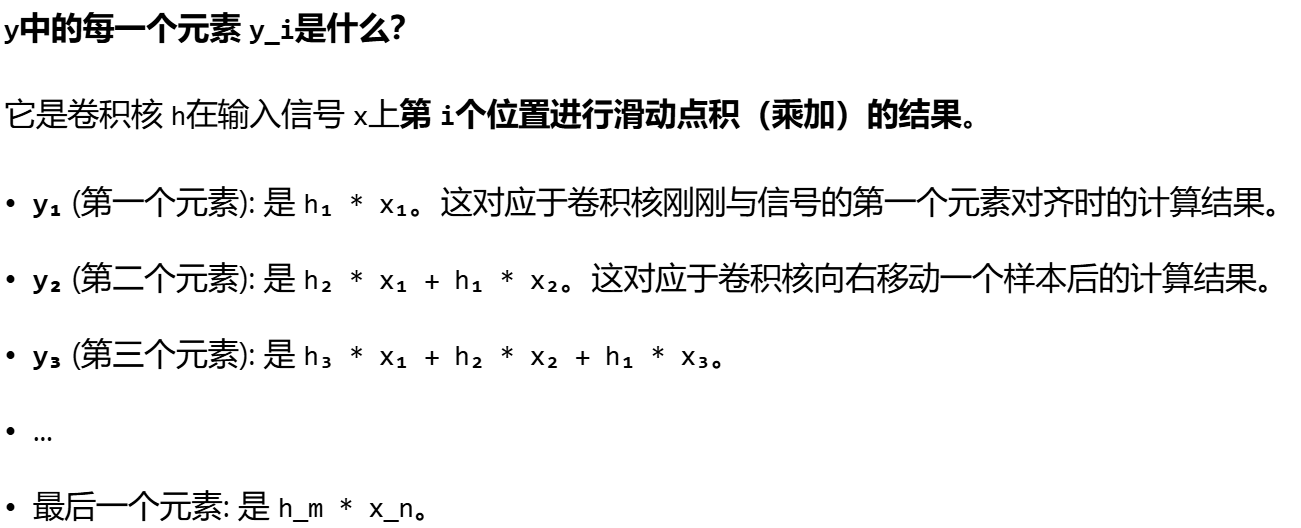
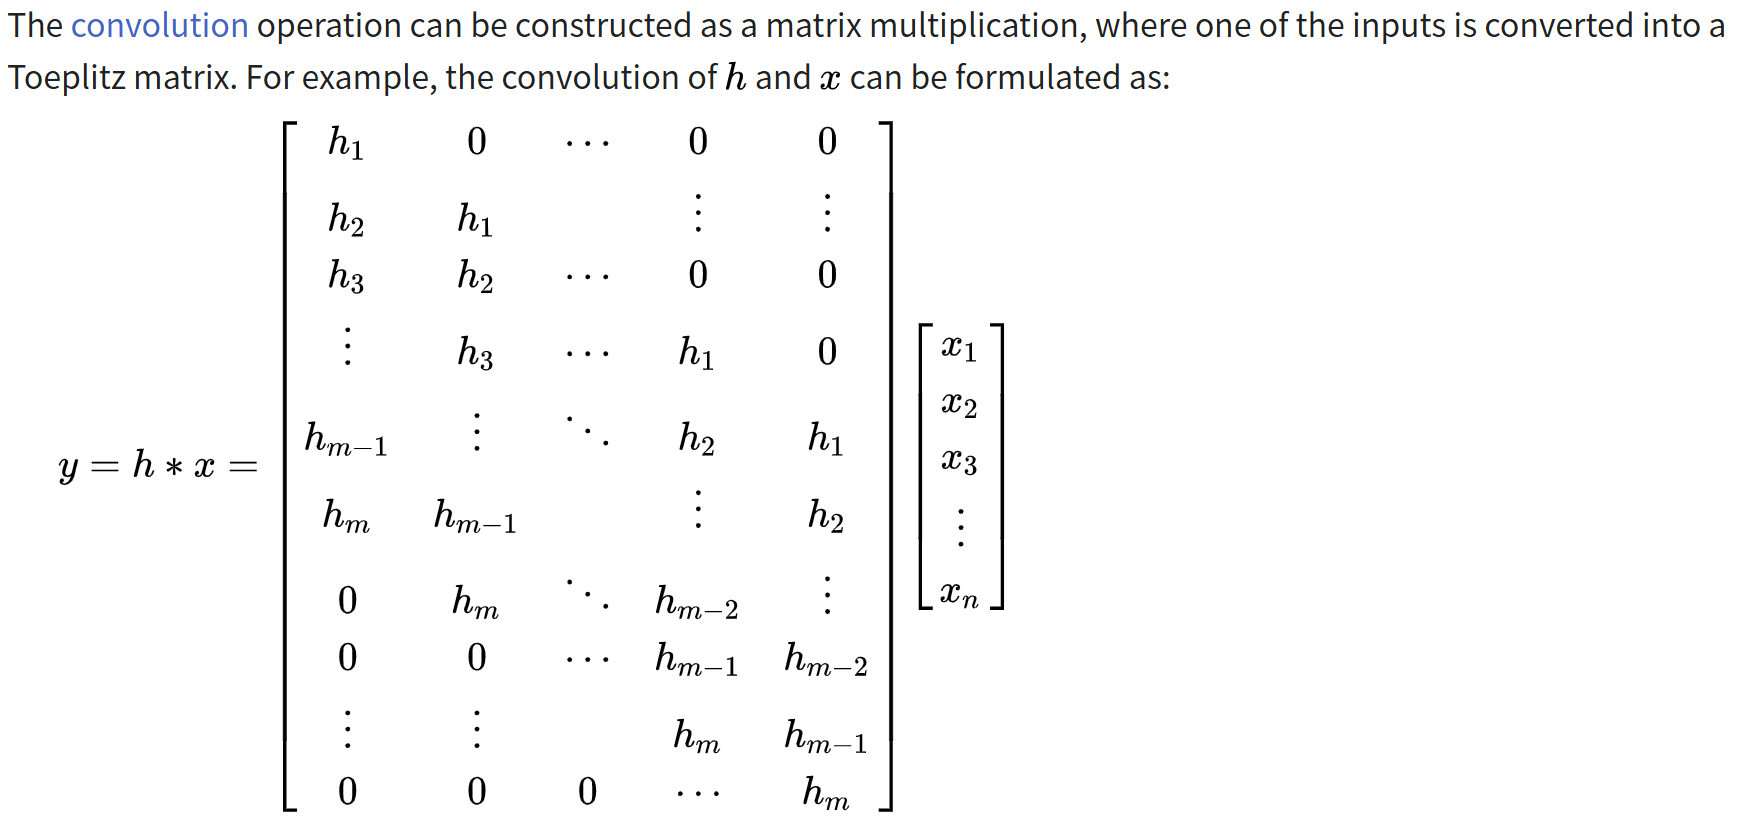

二维情况：
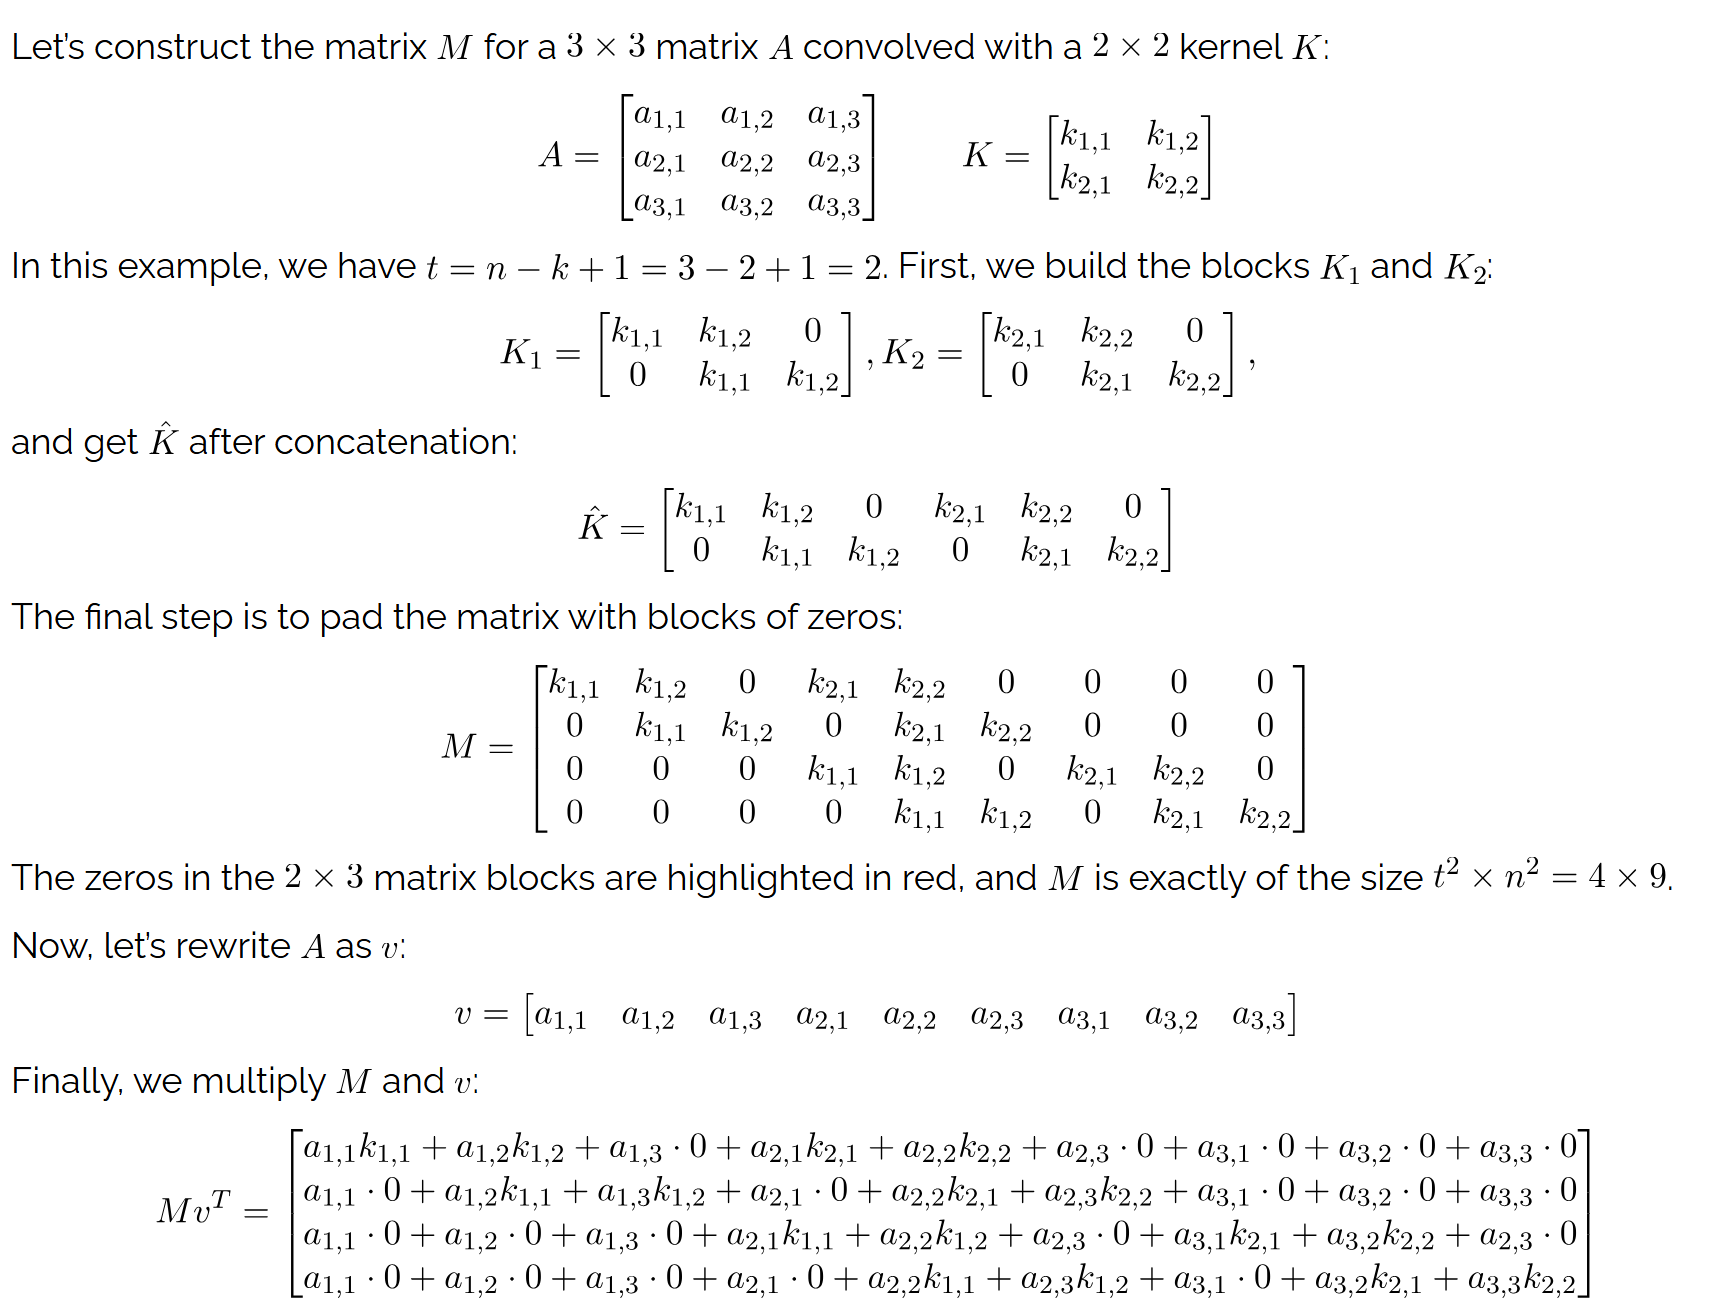

操作流程：
1.  **压平（矢量化）图像**: 把一个 `6x6` 的图像，按行（或按列）展开，变成一个 `36x1` 的长向量。
    `img_vector = [pixel(0,0), pixel(0,1), ..., pixel(0,5), pixel(1,0), ... pixel(5,5)]`

2.  **压平（矢量化）卷积核**: 同样，把 `3x3` 的卷积核压平成 `9x1` 的向量。

3.  **构建巨大的托普利茨矩阵**: 这是最难想象的一步。这个巨大的矩阵的**每一行**，都代表了卷积核在原图上**某一个特定位置**的运算。

### 构建Toeplitz Matrix
以一个 6x6 的图像，和一个 3x3 的卷积核为例  
1. 让我们来构建第一行，也就是计算 o(0,0) 的那一行。

问: 为了计算输出图像的第一个像素 o(0,0)，我们的 3x3 卷积核应该放在 8x8 填充后图像的哪个位置？  
答: 放在左上角。 

问: 这个 3x3 的区域覆盖了 8x8 填充后图像的哪些像素？  
答: p(0,0), p(0,1), p(0,2)  
p(1,0), p(1,1), p(1,2)  
p(2,0), p(2,1), p(2,2)

问: 这些像素在被压平的 64x1 输入向量中，是第几个元素（索引）？  
索引 = 行号 * 填充后宽度 + 列号  
p(0,0) -> 0*8 + 0 = 索引 0  
p(0,1) -> 0*8 + 1 = 索引 1  
p(0,2) -> 0*8 + 2 = 索引 2  
p(1,0) -> 1*8 + 0 = 索引 8  
p(1,1) -> 1*8 + 1 = 索引 9  
p(1,2) -> 1*8 + 2 = 索引 10  
p(2,0) -> 2*8 + 0 = 索引 16  
p(2,1) -> 2*8 + 1 = 索引 17  
p(2,2) -> 2*8 + 2 = 索引 18  
构建: 现在我们来构建Toeplitz矩阵的第一行。这一行有64个元素，它将与 64x1 的输入向量做点积。
我们把压平的 3x3 卷积核 [k0, k1, ..., k8] 的值，放到上面计算出的9个索引位置。
其他 55 个位置全部填 0！  
所以，第一行看起来像这样 (假设 k_flat 是压平的卷积核):  
Row 0 = [k0, k1, k2, 0, 0, 0, 0, 0, k3, k4, k5, 0, ..., 0, k6, k7, k8, 0, ..., 0]

2. 现在我们来构建第二行，它用来计算 o(0,1)
 
问: 为了计算 o(0,1)，卷积核在 8x8 图像上向右滑动了一格。它现在覆盖了哪些像素？这些像素在 64x1 向量中的索引是什么？  
答: 1, 2, 3, 9, 10, 11, 17, 18, 19。所有索引都比第一行对应的索引加了1！  
所以，第二行就是把第一行的非零元素块整体向右平移一格！  
Row 1 = [0, k0, k1, k2, 0, 0, 0, 0, 0, k3, k4, k5, 0, ..., 0, 0, k6, k7, k8, 0, ...]


#### 索引值的数学表达
我们来把这个过程从直观理解升华为一个普适的数学公式。

1. 定义所有变量  
首先，我们必须清晰地定义所有涉及的尺寸： 
- 原图尺寸: H × W (在作业中是 6 × 6)
- 卷积核尺寸: kH × kW (在作业中是 3 × 3)
- 填充尺寸: P (为了保持输出尺寸不变，P = floor(kH / 2)，在作业中是 1)
- 填充后图像尺寸: Hp × Wp
    - Hp = H + 2*P (在作业中是 6 + 2*1 = 8)
    - Wp = W + 2*P (在作业中是 6 + 2*1 = 8)
- 输出图像尺寸: Ho × Wo (在作业中是 6 × 6)

2. 核心公式  
我们的目标是：当我们在计算输出图像的 (r, c) 位置的像素值时 (Output(r, c))，卷积核内部的 (i, j) 位置的元素 (Kernel(i, j)) 对应的是压平后的填充图像向量中的哪个索引？  
这个索引 Index 的通用数学公式是： 

    Index(r, c, i, j) = (r + i) * Wp + (c + j)  

    其中：  
    (r, c): 你正在计算的输出像素的坐标 (0 <= r < Ho, 0 <= c < Wo)。  
    (i, j): 卷积核内部的相对坐标 (0 <= i < kH, 0 <= j < kW)。  
    Wp: 填充后图像的宽度。 

3. 证明

- 定位卷积核：为了计算输出像素 Output(r, c)，我们需要将 kH x kW 的卷积核覆盖在 Hp x Wp 的填充图像上。卷积的定义决定了卷积核的左上角会精确地放在填充图像的 (r, c) 位置。
- 定位核内元素：现在，我们关注卷积核内部的某个元素，它的相对坐标是 (i, j)。既然核的左上角在 (r, c)，那么这个核内元素在填充图像上的绝对坐标就是 (r + i, c + j)。
- 压平坐标：我们最后需要的是这个绝对坐标在一维向量中的索引。对于一个宽度为 Wp 的二维矩阵，将二维坐标 (y, x) 转换为一维索引的公式是 index = y * Wp + x。
- 代入：我们将第2步得到的绝对坐标 y = (r + i) 和 x = (c + j) 代入第3步的压平公式，就得到了最终的核心公式：Index = (r + i) * Wp + (c + j)

4. 总结
要构建整个36x64的Toeplitz矩阵，你的程序需要：  
- 创建一个 36x64 的全零矩阵 T。
- 压平你的 3x3 卷积核，得到一个 9x1 的向量 k_flat。
- 遍历所有输出像素坐标 (r, c) (从 (0,0) 到 (5,5))。
- 对于每一个 (r, c)，计算它对应的Toeplitz矩阵的行号 row_index = r * Wo + c。
-  在 (r, c) 的循环内部，再遍历卷积核的内部坐标 (i, j) (从 (0,0) 到 (2,2))。
- 对于每一个 (i, j)，使用核心公式 col_index = (r + i) * Wp + (c + j) 计算出它在Toeplitz矩阵中的列号。
- 同时，计算出 (i, j) 在压平的卷积核 k_flat 中的索引 k_index = i * kW + j。
- 执行赋值：T[row_index, col_index] = k_flat[k_index]。


### 代码实现

In [1]:
import numpy as np

def convol_with_Toeplitz_matrix(img, kernel):
    """
    使用Toeplitz矩阵执行2D卷积。
    Inputs:
        img: array(float) 6x6
        kernel: array(float) 3x3
    Outputs:
        output: array(float) 6x6
    """

    # === 步骤 1: 定义尺寸并准备输入 ===
    
    img_h, img_w = img.shape         # 原图尺寸: 6, 6
    kernel_h, kernel_w = kernel.shape # 卷积核尺寸: 3, 3
    
    # 根据作业要求，我们需要进行零填充，以保持输出尺寸不变
    padding_size = 1
    
    # 填充后的图像尺寸
    padded_h = img_h + 2 * padding_size # 8
    padded_w = img_w + 2 * padding_size # 8
    
    # 输出图像的尺寸
    output_h = img_h # 6
    output_w = img_w # 6
    
    # 将2D图像和卷积核“压平”成1D向量
    padded_img = padding(img, padding_size, "zeroPadding") 
    padded_img_flat = padded_img.flatten() # 压平8x8图像 -> (64,) 向量
    kernel_flat = kernel.flatten()         # 压平3x3卷积核 -> (9,) 向量

    # === 步骤 2: 生成所有索引坐标 ===
    # 这是最核心的矢量化技巧。我们的目标是不用循环，一次性生成所有需要的索引。
    
    # a. 生成所有输出像素的坐标(r, c)，从 (0,0)到(5,5)
    output_y_coords = np.repeat(np.arange(output_h), output_w) # [0,0..0, 1,1..1, ..., 5,5..5]
    output_x_coords = np.tile(np.arange(output_w), output_h)   # [0,1..5, 0,1..5, ..., 0,1..5]
    
    # b. 生成卷积核内部的相对偏移坐标(i, j)，从(0,0)到(2,2)
    kernel_y_offsets = np.repeat(np.arange(kernel_h), kernel_w) # [0,0,0, 1,1,1, 2,2,2]
    kernel_x_offsets = np.tile(np.arange(kernel_w), kernel_h)   # [0,1,2, 0,1,2, 0,1,2]

    # === 步骤 3: 构建 Toeplitz 矩阵 ===
    # 现在我们利用广播(Broadcasting)机制，将步骤2的坐标组合起来，实现我们的通用公式。
    
    # a. 创建一个 36x64 的全零矩阵作为画布
    toeplitz_matrix = np.zeros((output_h * output_w, padded_h * padded_w))
    
    # b. 计算每一行中，卷积核元素应该被放置的“列索引”
    #    这里是通用公式 `Index = (r + i) * Wp + (c + j)` 的矢量化实现！
    #    output_y_coords[:, np.newaxis] 将 (36,) 向量变为 (36, 1) 的列向量
    #    当 (36, 1) 和 (9,) 向量相加时，它们会广播成一个 (36, 9) 的矩阵
    y_part = (output_y_coords[:, np.newaxis] + kernel_y_offsets) * padded_w
    x_part = output_x_coords[:, np.newaxis] + kernel_x_offsets
    
    # col_indices 是一个 36x9 的矩阵。
    # 每一行代表一个输出像素，9列代表了计算这个输出所需的9个输入像素的索引。
    col_indices = (y_part + x_part).astype(int)
    
    # c. 确定这些值应该被放置在 Toeplitz 矩阵的哪“一行”
    #    我们有36个输出，所以有36行。每个输出需要9个值，所以行索引也要重复9次。
    row_indices = np.repeat(np.arange(output_h * output_w), kernel_h * kernel_w)
    
    # d. 将卷积核的值“散布”到Toeplitz矩阵的正确位置
    #    我们使用 `col_indices.flatten()` 将36x9的矩阵压平，与 `row_indices` 对应
    #    `np.tile(kernel_flat, ...)` 准备好了要填充进去的值
    toeplitz_matrix[row_indices, col_indices.flatten()] = np.tile(kernel_flat, output_h * output_w)

    # === 步骤 4: 执行卷积（矩阵乘法） ===
    # 经过所有准备，真正的卷积运算现在只是一次简单的矩阵乘法。
    
    # (36x64) @ (64,) -> (36,)
    convolution_result_flat = toeplitz_matrix @ padded_img_flat
    
    # === 步骤 5: Reshape 输出 ===
    # 将压平的 (36,) 结果向量，重新变回 6x6 的二维图像。
    
    output = convolution_result_flat.reshape(output_h, output_w)
    
    return output

#### 代码解释

1. 广播
```python
y_part = (output_y_coords[:, np.newaxis] + kernel_y_offsets) * padded_w
x_part = output_x_coords[:, np.newaxis] + kernel_x_offsets


output_y_coords[:, np.newaxis]使得：
原始: [0, 0, 0, 1, 1, 1, 2, 2, 2]  # 形状 (9,)
变成: [[0],    # 形状 (9, 1)
       [0], 
       [0],
       [1],
       [1],
       [1], 
       [2],
       [2],
       [2]]
output_y_coords[:, np.newaxis]: [[0], [0], [0], [1], [1], [1], [2], [2], [2]] 
kernel_y_offsets: [0, 0, 1, 1] 

广播后:
┌──────┬──────┬──────┬──────┐
│ 0+0  │ 0+0  │ 0+1  │ 0+1  │  # 第0个输出位置 + 所有内核偏移
├──────┼──────┼──────┼──────┤
│ 0+0  │ 0+0  │ 0+1  │ 0+1  │  # 第1个输出位置 + 所有内核偏移  
├──────┼──────┼──────┼──────┤
│ 0+0  │ 0+0  │ 0+1  │ 0+1  │  # 第2个输出位置 + 所有内核偏移
├──────┼──────┼──────┼──────┤
│ 1+0  │ 1+0  │ 1+1  │ 1+1  │  # 第3个输出位置 + 所有内核偏移
├──────┼──────┼──────┼──────┤
│ 1+0  │ 1+0  │ 1+1  │ 1+1  │
├──────┼──────┼──────┼──────┤
│ 1+0  │ 1+0  │ 1+1  │ 1+1  │
├──────┼──────┼──────┼──────┤
│ 2+0  │ 2+0  │ 2+1  │ 2+1  │
├──────┼──────┼──────┼──────┤
│ 2+0  │ 2+0  │ 2+1  │ 2+1  │
└──────┴──────┴──────┴──────┘

结果: [[0, 0, 1, 1], 
       [0, 0, 1, 1], 
       [0, 0, 1, 1],
       [1, 1, 2, 2],
       [1, 1, 2, 2],
       [1, 1, 2, 2],
       [2, 2, 3, 3],
       [2, 2, 3, 3],
       [2, 2, 3, 3]]  # 形状 (9, 4)

之所以可以让他自动延展，因为同一行内的output坐标(r,c)相同，只是卷积核内的相对坐标不同


## Convolution by sliding window

In [ ]:
import numpy as np

def convolve(img, kernel):
    """
    Implements 2D convolution using a sliding window approach without loops.
    Assumes no padding.
    
    Inputs:
        img: array(float), input image of arbitrary shape
        kernel: array(float), k x k kernel
    Outputs:
        output: array(float), convolution result
    """
    
    # === 步驟 1: 获取尺寸 ===
    # 这是我们的准备工作，定义所有相关的尺寸。
    img_h, img_w = img.shape
    kernel_h, kernel_w = kernel.shape
    
    # 由于没有填充，输出尺寸会变小
    output_h = img_h - kernel_h + 1
    output_w = img_w - kernel_w + 1
    
    # === 步驟 2: 生成所有窗口的索引 ===
    # 这是没有循环的魔法发生的地方。我们将一次性生成所有窗口内所有像素的坐标。
    
    # a. 生成卷积核内部的相对偏移坐标 (i, j)
    #    对于 3x3 核, i_offsets = [[0,0,0],[1,1,1],[2,2,2]], j_offsets = [[0,1,2],[0,1,2],[0,1,2]]
    i_offsets, j_offsets = np.meshgrid(np.arange(kernel_h), np.arange(kernel_w), indexing='ij')

    # b. 生成所有窗口左上角顶点的坐标 (r, c)
    #    对于 5x5 图和 3x3 核, r_starts = [[0,0,0],[1,1,1],[2,2,2]], c_starts = [[0,1,2],[0,1,2],[0,1,2]]
    r_starts, c_starts = np.meshgrid(np.arange(output_h), np.arange(output_w), indexing='ij')

    # c. 使用广播(Broadcasting)将顶点和偏移量组合起来，得到绝对坐标
    #    我们使用 np.newaxis 来增加维度，以便Numpy可以正确地广播数组。
    #    (output_h, output_w, 1, 1) + (1, 1, kernel_h, kernel_w) -> (output_h, output_w, kernel_h, kernel_w)
    #    这个4D数组的每个元素都是一个绝对坐标。
    Y = r_starts[:, :, np.newaxis, np.newaxis] + i_offsets[np.newaxis, np.newaxis, :, :]
    X = c_starts[:, :, np.newaxis, np.newaxis] + j_offsets[np.newaxis, np.newaxis, :, :]

    # === 步驟 3: 提取所有窗口的像素值 ===
    # 我们使用步骤2中生成的4D索引数组，一次性从原图中“抠”出所有窗口。
    # all_windows 的维度是 (output_h, output_w, kernel_h, kernel_w)
    all_windows = img[Y, X]
    
    # === 步驟 4: 构建最终的矩阵并执行卷积 ===
    
    # a. 将4D的窗口集合 reshape 成作业提示的 2D 矩阵
    #    每一行代表一个被压平的窗口。
    #    矩阵维度: (output_h * output_w, kernel_h * kernel_w)
    #    这正是提示中 `(N-k+1)² x k²` 的矩阵！
    all_windows_matrix = all_windows.reshape(output_h * output_w, -1)
    
    # b. 将卷积核压平成一个向量
    kernel_flat = kernel.flatten()
    
    # c. 执行点积！
    #    ( (output_h*w), (kernel_h*w) ) @ ( (kernel_h*w), ) -> ( (output_h*w), )
    #    这一步就完成了所有的乘法和加法，得到了一个包含所有结果的一维向量。
    convolution_result_flat = np.dot(all_windows_matrix, kernel_flat)
    
    # === 步驟 5: 将结果 Reshape 成二维图像 ===
    output = convolution_result_flat.reshape(output_h, output_w)
    
    return output

### 代码解释
1. 步骤三
```python
Y = r_starts[:, :, np.newaxis, np.newaxis] + i_offsets[np.newaxis, np.newaxis, :, :]
X = c_starts[:, :, np.newaxis, np.newaxis] + j_offsets[np.newaxis, np.newaxis, :, :]
```
这个4D数组的每个元素都是一个绝对坐标。  
Y[r, c, i, j] 的值，精确地等于 r_starts[r, c] 加上 i_offsets[i, j]。Y[r, c, i, j]返回值即为当核放在(r,c)上面时候核的(i,j)处于整个图像的Y坐标。

`np.newaxis`放置位置：r_starts[:, :, np.newaxis, np.newaxis] 放在后面是因为对于放在同一个位置的卷积核，其内所有点的坐标都是(r,c)不变，直接在广播时候复制原来r_start(r,c)位置的值即可。同理i_offsets[np.newaxis, np.newaxis, :, :]放在前面是因为对于卷积核内某一位置，其内所有点的坐标都是(i,j)不变。

- Y[1, 2, 2, 0] 的值就是 r_starts 在 (1,2) 位置的值（即 1），加上 i_offsets 在 (2,0) 位置的值（即 2），结果是 3。
- Y[0, 0, 0, 0] 的值就是 r_starts 在 (0,0) 位置的值（即 0），加上 i_offsets 在 (0,0) 位置的值（即 0），结果是 0。

2. 步骤4.a
```python
all_windows_matrix = all_windows.reshape(output_h * output_w, -1)
```

第一个参数 ：行数 = output_h * output_w  
每行代表一个输出位置的窗口

第二个参数 -1：自动计算列数  
NumPy 会自动算出总共有多少元素，然后 总元素数 ÷ 行数 = 列数

## Test and Result

HM1_Convolve_img_blur

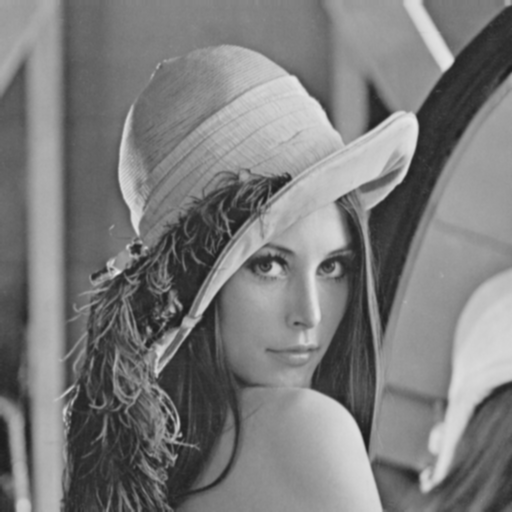

HM1_Convolve_img_gadient_x

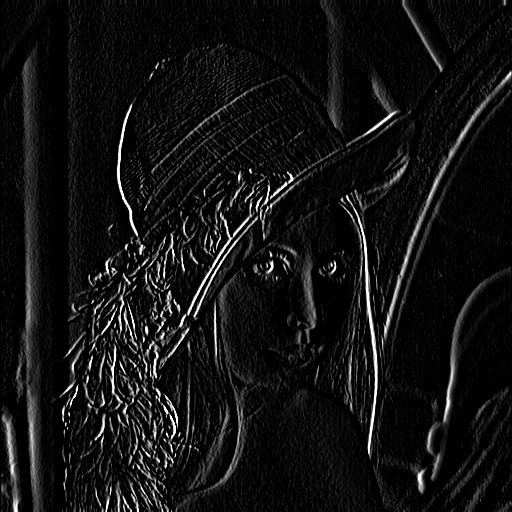

HM1_Convolve_img_gadient_y

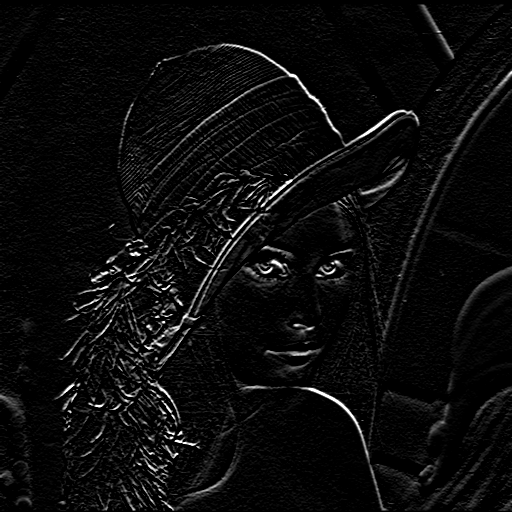